In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict


from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

sys.path.append('..')

from utils.dataset import DatasetReader
from utils.metrics import mse, psnr
from models.baseline import Baseline

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(0)

# Get Data

In [4]:
dr = DatasetReader(dataset_path='../temp/PUC_DIR')

In [5]:
x_train, y_train, x_val, y_val, _, _ = dr.get_dataset()

In [6]:
x_train[0].shape, y_train[0].shape

((32, 32), (64, 64))

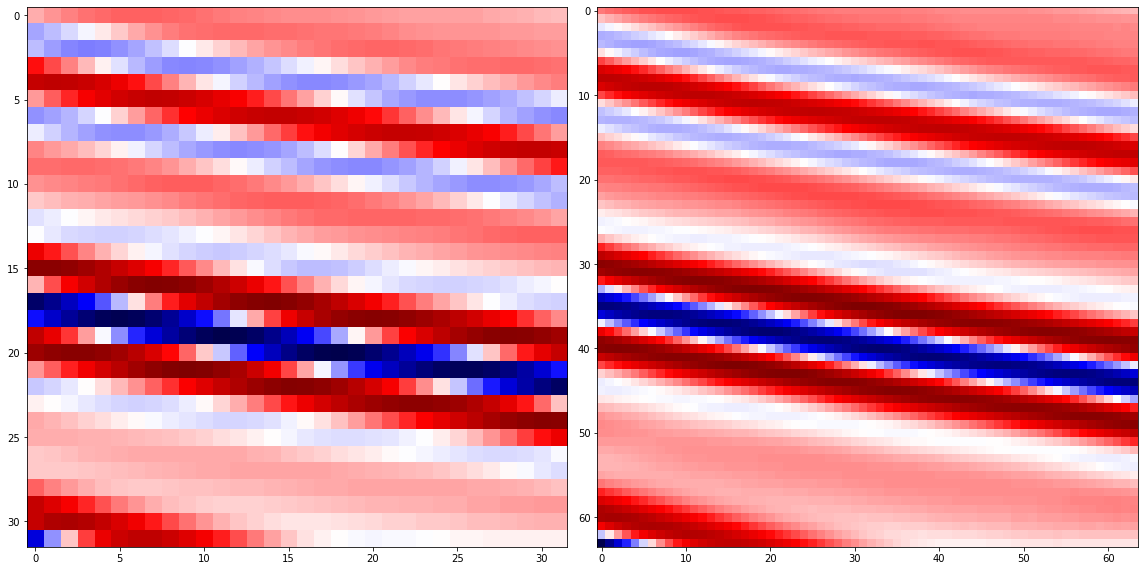

In [7]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(x_train[999], cmap='seismic')

ax[1].imshow(y_train[999], cmap='seismic')

plt.tight_layout()
plt.show()

# Conv

In [245]:
tf.keras.backend.set_floatx('float64')

class Conv(tf.keras.Model):
    def __init__(self, filters=32, original_dim=64, learning_rate=0.001, activ_hidden=tf.nn.relu, activ_out=None):
        super(Conv, self).__init__()
        
        self.resolution = original_dim
        
        self.sfe1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same'
        )
        
        self.sfe2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same'
        )
        
        # RDB
        self.rdb1_1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=tf.nn.relu,
            padding='same'
        )
        self.rdb2_1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=tf.nn.relu,
            padding='same'
        )
        self.rdb3_1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=tf.nn.relu,
            padding='same'
        )
        self.rdb4_1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(1, 1),
            activation=tf.nn.relu,
            padding='same'
        )
        
        self.rdb1_2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=tf.nn.relu,
            padding='same'
        )
        self.rdb2_2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=tf.nn.relu,
            padding='same'
        )
        self.rdb3_2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=tf.nn.relu,
            padding='same'
        )
        self.rdb4_2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(1, 1),
            activation=tf.nn.relu,
            padding='same'
        )
        
        #########
        
        self.conv1x1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same'
        )
        
        self.conv_gf = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same'
        )
        
        self.upsample = tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=(3, 3),
            strides=(2, 2),
            activation=tf.nn.tanh,
            padding='same'
        )
        
        self.output_layer = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=(1, 1),
            activation=activ_out,
            padding='same'
        )
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        self.loss_metric = tf.keras.metrics.MeanSquaredError()
        self.loss = tf.keras.losses.MeanSquaredError()
        self.log_metrics = defaultdict(list)
        
    def call(self, input_features):
        x = tf.expand_dims(input_features, -1)
        f_m1 = self.sfe1(x)
        f_0 = self.sfe2(f_m1)
        
        # RDB
        rdb1 = self.rdb1_1(f_0)
        rdb2 = self.rdb2_1(f_0+rdb1)
        rdb3 = self.rdb3_1(f_0+rdb1+rdb2)
        f_1 = self.rdb4_1(tf.concat([f_0, rdb1, rdb2, rdb3], axis=-1)) + f_0
        
        rdb1 = self.rdb1_2(f_1)
        rdb2 = self.rdb2_2(f_1+rdb1)
        rdb3 = self.rdb3_2(f_1+rdb1+rdb2)
        f_2 = self.rdb4_2(tf.concat([f_1, rdb1, rdb2, rdb3], axis=-1)) + f_1
        
        x = self.conv1x1(tf.concat([f_1, f_2], axis=-1))
        
        f_gf = self.conv_gf(x)
        
        x = self.upsample(f_gf + f_m1)
        x = self.output_layer(x)
        return tf.squeeze(x)

    @tf.function
    def train(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self(x)
            
            loss_value = self.loss(predictions, y)
            
            self.loss_metric.update_state(predictions, y)
                        
            gradients = tape.gradient(loss_value, self.trainable_variables)
            
            gradient_variables = zip(gradients, self.trainable_variables)
            
            self.optimizer.apply_gradients(gradient_variables)
            
            return loss_value

    def make_dataset(self, x, y, x_val, y_val):
        x_train = tf.data.Dataset.from_tensor_slices(x)
        x_val = tf.data.Dataset.from_tensor_slices(x_val)
        
        y_train = tf.data.Dataset.from_tensor_slices(y)
        y_val = tf.data.Dataset.from_tensor_slices(y_val)
            
        return x_train, y_train, x_val, y_val

    def train_epochs(self, x_train, y_train, x_val, y_val, n_epochs, batch_size, SEED=42):
        x_train, y_train, x_val, y_val = self.make_dataset(x_train, y_train, x_val, y_val)
        loss = []
        for epoch in range(n_epochs):
            loss_val = []
            batches_x = x_train.batch(batch_size)
            batches_y = y_train.batch(batch_size)
            
            # Training loop
            for _x, _y in zip(batches_x, batches_y):
                self.train( _x, _y)
            
            batches_x_val = x_val.batch(batch_size)
            batches_y_val = y_val.batch(batch_size)
            
            # Validation loop
            for _x, _y in zip(batches_x, batches_y):
                loss_val.append(self.loss(self(_x), _y))

            loss_train = self.loss_metric.result().numpy()
            
            if epoch%5 == 0 or epoch == 0:
                print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
            loss.append(np.mean(loss_val))

            self.log_metrics['loss_train'].append(loss_train)
            self.log_metrics['loss_val'].append(np.mean(loss_val))

            self.loss_metric.reset_states()
       
        print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
        return pd.DataFrame(self.log_metrics)


In [318]:
filters=64
epochs = 120

In [313]:
model = Conv(filters=filters)
model.load_weights(f'../models/neural_networks/weights/RDN/{filters}/RDN_{epochs}.ckpt')

In [285]:
_ = model(np.random.random_sample((1, 32, 32)))

model.summary()

Model: "conv_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_228 (Conv2D)          multiple                  640       
_________________________________________________________________
conv2d_229 (Conv2D)          multiple                  36928     
_________________________________________________________________
conv2d_230 (Conv2D)          multiple                  36928     
_________________________________________________________________
conv2d_231 (Conv2D)          multiple                  36928     
_________________________________________________________________
conv2d_232 (Conv2D)          multiple                  36928     
_________________________________________________________________
conv2d_233 (Conv2D)          multiple                  16448     
_________________________________________________________________
conv2d_234 (Conv2D)          multiple                  3692

## Train

In [319]:
result = model.train_epochs(x_train, y_train, x_val, y_val, 20, 64)

Epoch: 0 Train Loss: 1.6724488285380573e-06 Validation Loss: 1.6157775917235995e-06
Epoch: 5 Train Loss: 2.2676188256690456e-06 Validation Loss: 1.7833675656220294e-06
Epoch: 10 Train Loss: 1.768224999340167e-06 Validation Loss: 1.6099322692753049e-06
Epoch: 15 Train Loss: 1.5240882062910157e-06 Validation Loss: 1.5159554322963231e-06
Epoch: 19 Train Loss: 2.3821741512724623e-06 Validation Loss: 1.5819620102774934e-06


In [327]:
# result.plot()

In [328]:
# result[5:].plot()

In [329]:
# result[20:].plot()

In [323]:
y = model(x_val)

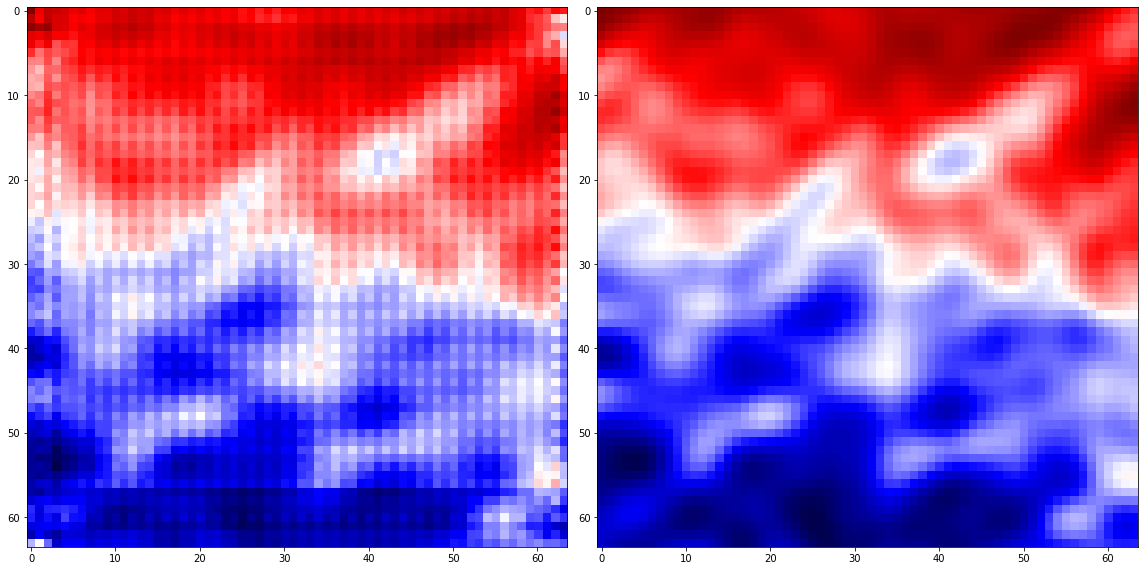

In [324]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[1], cmap='seismic')

ax[1].imshow(y_val[1], cmap='seismic')

plt.tight_layout()
plt.show()

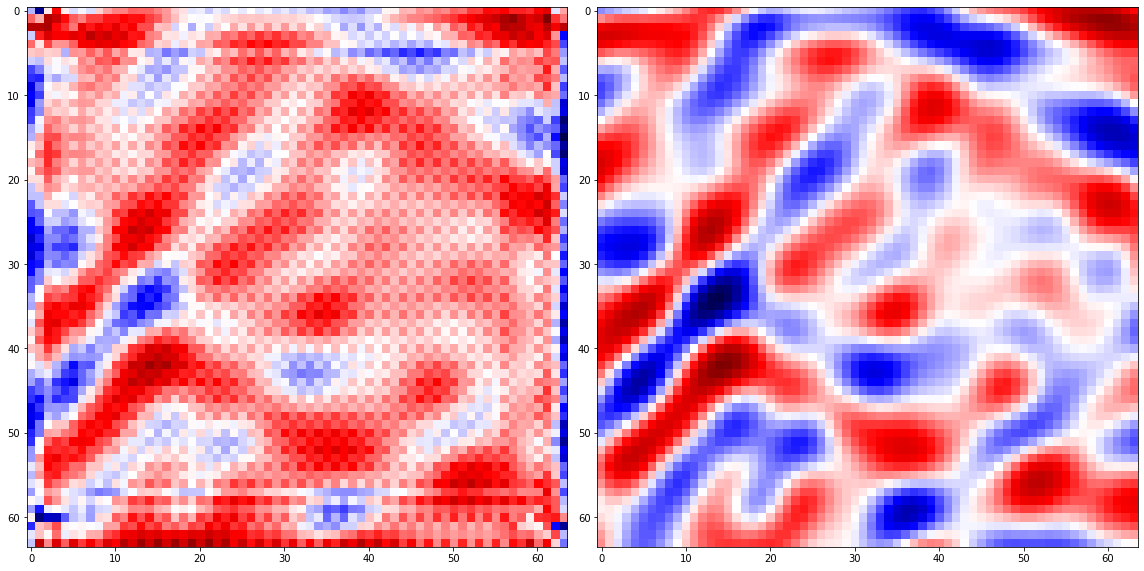

In [325]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[21], cmap='seismic')

ax[1].imshow(y_val[21], cmap='seismic')

plt.tight_layout()
plt.show()

In [326]:
_ = mse(y_val, y)
_ = psnr(y_val, y)

Mean MSE 2.7233032513579437e-06
Mean PSNR 63.80269401630472


In [294]:
model.save_weights(f'../models/neural_networks/weights/RDN/{filters}/RDN_{epochs}.ckpt')

### MLP

Mean MSE 4.691019780326341e-06

Mean PSNR 59.72909565394992

### Baseline

In [276]:
baseline = Baseline()
y_b = baseline.predict(x_val)
_ = baseline.evaluate(x_val, y_val)

Mean MSE 5.5883268989610134e-05
Mean PSNR 57.02503037626504


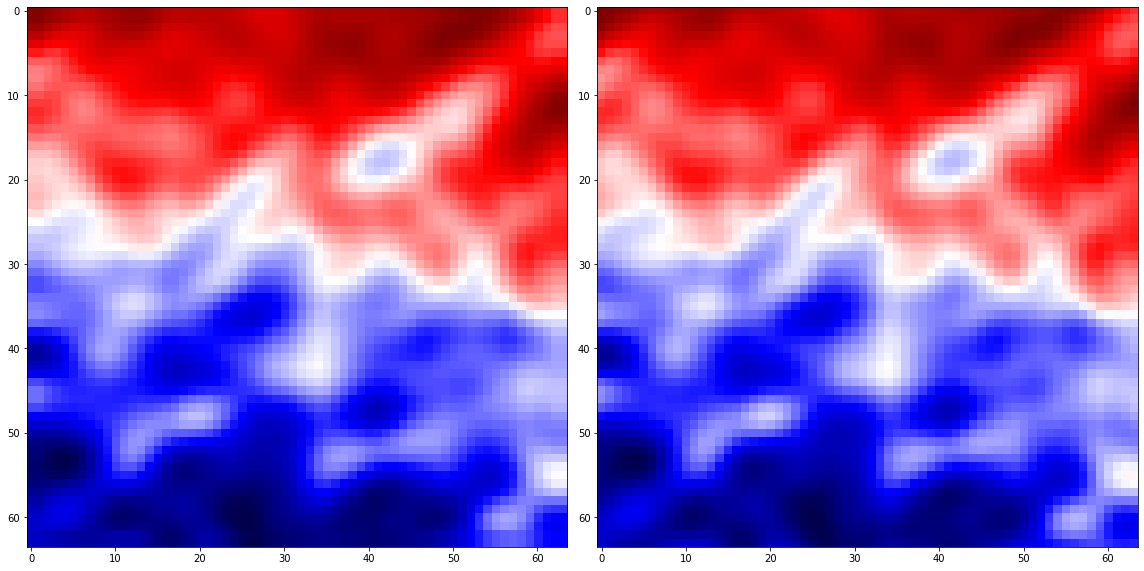

In [277]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y_b[1], cmap='seismic')

ax[1].imshow(y_val[1], cmap='seismic')

plt.tight_layout()
plt.show()

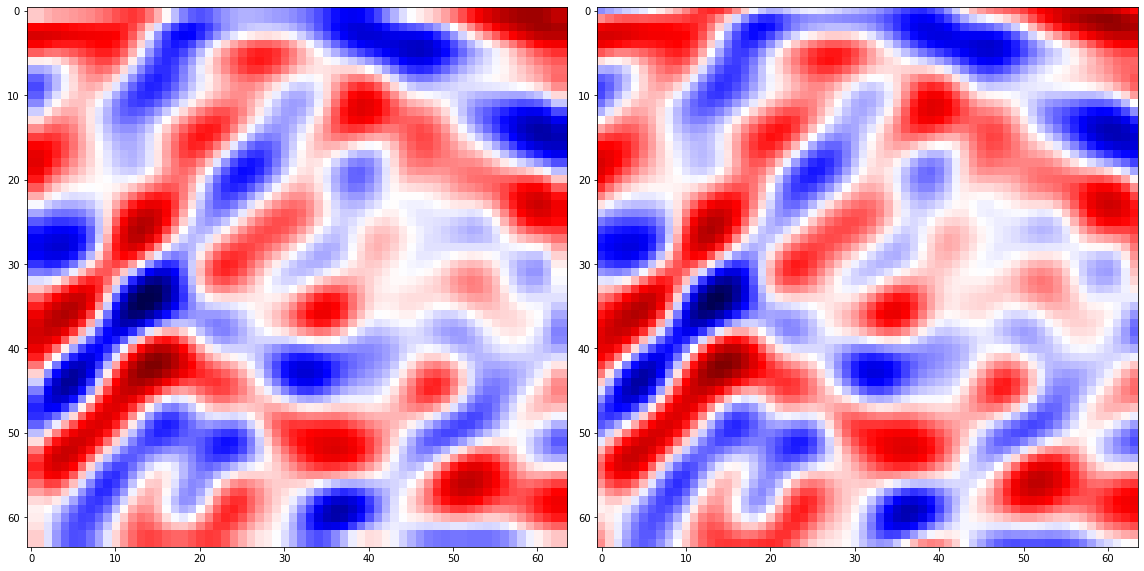

In [278]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y_b[21], cmap='seismic')

ax[1].imshow(y_val[21], cmap='seismic')

plt.tight_layout()
plt.show()